In [ ]:
# Data Loader
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
from pytorch_lightning.utilities.types import EVAL_DATALOADERS, TRAIN_DATALOADERS
import pytorch_lightning as pl
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.utils.data import random_split
import json
from CustomDataset import * 
import sys
sys.path.append('../')
from config import *
from file_helper import *

def collate_fn(batch):
    return tuple(zip(*batch))
#=================================
#             Augmentation
#=================================

def gauss_noise_tensor(img):
    rand = torch.rand(1)[0]
    if rand < 0.5 and Horizon_AUG:
        sigma = rand *0.125
        out = img + sigma * torch.randn_like(img)
        return out
    return img

def blank(img):    
    return img

class CustomDataModule(pl.LightningDataModule):
    def __init__(self ,
                 train_dir ,
                 test_dir , batch_size = 2, num_workers = 0 , img_size=[IMG_WIDTH, IMG_HEIGHT] , use_aug = True ,padding_count = 24 ,c =0.1
                   ):
        super().__init__()
        self.train_dir = train_dir
        self.test_dir = test_dir
        
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.img_size = img_size      
        self.use_aug = use_aug
        self.padding_count  = padding_count
        self.c = c
        

        pass

    def prepare_data(self) -> None:
        # Download dataset
        pass

    def setup(self, stage):
        # Create dataset...          
                
        self.entire_dataset = CustomDataset(self.train_dir  , use_aug= self.use_aug , padding_count= self.padding_count , c=self.c)
        self.train_ds , self.val_ds = random_split(self.entire_dataset , [0.9, 0.1])        
        self.test_ds = CustomDataset(self.test_dir  , use_aug= False)
        
        pass

    # ToDo: Reture Dataloader...
    def train_dataloader(self) -> TRAIN_DATALOADERS:
        return DataLoader(self.train_ds , batch_size= self.batch_size , num_workers= self.num_workers , shuffle=True)
    
    def val_dataloader(self) -> EVAL_DATALOADERS:
        return DataLoader(self.val_ds , batch_size= self.batch_size , num_workers= self.num_workers , shuffle=False)
    
    def test_dataloader(self) -> EVAL_DATALOADERS:
        return DataLoader(self.test_ds , batch_size= self.batch_size , num_workers= self.num_workers , shuffle=False)

    pass


# Test
dm = CustomDataModule ( train_dir= f"../anno/test_visiable_10_no_cross.json" ,
                       test_dir= f"../anno/test_visiable_10_no_cross.json" , padding_count=256
                       )

In [ ]:
from torch import Tensor
def unpad_data( x :[Tensor] ) :
	non_zero_indices = torch.nonzero(x)
	#print(non_zero_indices)
	# Get the non-zero values
	non_zero_values = x[non_zero_indices[:,0], non_zero_indices[:,1]]

	unique = torch.unique(non_zero_indices[:,0] ,return_counts=True)	
	non_zero_values = torch.split(non_zero_values , tuple(unique[1]))
	
	return non_zero_values

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from typing import Any
import pytorch_lightning as pl
from config import *
import torchvision.models as models
from torchvision.ops import MLP
import math
from torch import Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
from VerticalCompressionNet import * 
from CustomTransformer import *

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: 256, dropout: float = 0.1, max_len: int = 1024):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        r"""Inputs of forward function
        Args:
            x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        Examples:
            >>> output = pos_encoder(x)
        """

        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


class TransformerModel(nn.Module):
    def __init__(self, d_model: int, nhead: int , d_hid: int, nlayers: int, dropout: float = 0.1 , activation="relu" , normalize_before=False , out_dim=20):
        super().__init__()
        #self.ntoken = ntoken
        self.model_type = 'Transformer'
        self.d_model = d_model
        self.out_dim =out_dim
        
        self.pe = PositionalEncoding(d_model,dropout)
        self.query_embed = nn.Embedding(out_dim, d_model)

        encoder_layer = TransformerEncoderLayer(d_model, nhead, d_hid,
                                                dropout, activation, normalize_before)
        encoder_norm = nn.LayerNorm(d_model) if normalize_before else None
        self.encoder = TransformerEncoder(encoder_layer, nlayers, encoder_norm)
        '''
       
        self.decoder = nn.Linear(out_dim, d_model)
        decoder_layer = nn.TransformerDecoderLayer(d_model=256, nhead=8  )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=6)
        '''

        self.decoder1 = nn.Conv1d(256 , 128 , kernel_size=3 , padding=1)
        self.decoder2 = nn.Conv1d(128 , 64 , kernel_size=1)
        self.decoder3 = nn.Conv1d(64 , self.out_dim , kernel_size=1)
        
        self.cls_head = nn.Linear(d_model, 1 )
        self.box_head = nn.Linear(d_model, 6 )
    
        
    def forward(self, src: Tensor ) -> Tensor:
        # permute to (Sequence_length , Batches , Hidden layer)
        '''
        plt.imshow(src[0].detach().cpu().numpy())
        plt.title("src")
        plt.show()
        '''
        #src         = src.permute(1 , 0 , 2)# torch.Size([1024, b, 256])        
        src         = src.permute(2 , 0 , 1)# torch.Size([256, b, 1024])                
        batch_size  = src.shape[1]        
        src_pe         = self.pe(src)   # [ 1024 , 2 , hidden_dim]

        src_pe         = src_pe.permute(1,0,2)
        print("src_pe" , src_pe.shape)
        '''
        src_pe         = self.encoder(src_pe)

        plt.imshow(src_pe[0].detach().cpu().numpy())
        plt.title("encoder output")
        plt.show()
        '''

        out = self.decoder1(src_pe)        
        out = torch.relu(out)
        out = self.decoder2(out)        
        out = torch.relu(out)
        out = self.decoder3(out)        
        out = torch.relu(out)        
      
        box_logits = self.box_head(out)
        cls_logits = self.cls_head(out)
        

        return box_logits ,cls_logits


class VerticalAttention(nn.Module):

    def __init__(self, d_model , dropout=0.1 , seq_len = 1024):
        super().__init__()
        self.pe                     = PositionalEncoding(d_model , dropout , seq_len)
        self.vertical_compression   = nn.Conv1d(d_model , 1 , kernel_size=3 , padding=1)
        self.act                    = nn.ReLU()
        self.layer_norm             = nn.LayerNorm(1)


    def forward(self, x):
        '''
        # Input:
        #   x : shape  [b , channel , height , width ]
        '''
        # vertical 
        #x = x.permute( ,0 )  # x: [sequence length, batch size, embed dim]
        
        pass

    

class VerticalQueryTransformer(pl.LightningModule):    
    def __init__(self  ,  max_predict_count = 24 ,
                    hidden_out = 128 , class_num = 1 ,
                    log_folder = "__test" , num_classes = 1 , backbone_trainable =False, load_weight ="" , top_k = 20 
                    ):
        #print(" input_size" ,  input_size)
        super().__init__()
        self.backbone = Resnet()
        self.out_scale = 8
        self.step_cols = 4        
        self.hidden_size = hidden_out
        self.max_predict_count = max_predict_count
        self.num_classes  = num_classes 
        self.top_k_num = top_k        

        self.fixed_pe = PositionalEncoding(hidden_out, 0.1 , 256)

        #self.transformer = TransformerModel( d_model=hidden_out , nhead=8 , d_hid= 256,nlayers=6 ,out_dim=max_predict_count)
        self.transformer = TransformerModel( d_model= 1024 , nhead=8 , d_hid= 512,nlayers=6 ,out_dim=max_predict_count)
        #self.transformer = nn.TransformerEncoderLayer(hidden_out ,  8 , 2048 , dropout= 0.1) 

        self.confidence_threshold = 0.9

        # loss
        self.box_cost = 1
        self.cls_cost = 5

        self.log_folder = create_folder(os.path.join(os.getcwd() , "output" , log_folder))
        

        # Inference channels number from each block of the encoder
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 320, 190)
            c1, c2, c3, c4 = [b.shape[1] for b in self.backbone(dummy)] # resnet feature channel數
            #print("c1, c2, c3, c4" , c1, c2, c3, c4)
            c_last = (c1*8 + c2*4 + c3*2 + c4*1) // self.out_scale            
        #self.v_reproj = nn.Conv2d(1024 , self.max_predict_count,kernel_size=1)
            
        self.reduce_height_module = GlobalHeightStage(c1, c2, c3, c4 , out_scale=self.out_scale , pretrain_weight= load_weight , freeze_model= not backbone_trainable)

    def post_process(self ,box_coord , index , max_length = 1024):
        '''
        box_coord : contains left top v ,left btm v , du , right top v , right btm v
        '''
        origin_shape = box_coord.shape
        box_coord = box_coord.view(-1 , 5)
        
        us = (index/max_length).view((box_coord.shape[0] , 1))
        uvv_uvv_b = torch.zeros((box_coord.shape[0] , 6) , device=box_coord.device)
        uvv_uvv_b[:,0] = us[:,0]
        uvv_uvv_b[:,1] = box_coord[:,0] # left top v
        uvv_uvv_b[:,2] = box_coord[:,1] # left btm v
        uvv_uvv_b[:,3] = us[:,0] + box_coord[:,2] # right u
        uvv_uvv_b[:,4] = box_coord[:,3] # right top v
        uvv_uvv_b[:,5] = box_coord[:,4] # right btm v

        #return uvv_uvv_b.view(origin_shape[0] , origin_shape[1] , 6)
        return uvv_uvv_b.view(origin_shape[0] , -1 , 6)

        pass

    def forward(self ,x ):
        features = self.backbone(x) # [4 , c , h, w]              
        '''
            # Feature shape
            [2, 256, 128, 256]
            [2, 512, 64, 128]
            [2, 1024, 32, 64]
            [2, 2048, 16, 32]
        '''


        # vertical feature
        reduced_feats  = self.reduce_height_module(features , x.shape[3]//self.step_cols ) # [b , 1024 ,  256] width = 1024 , 256d latent code each.
        #plt.imshow(reduced_feats[0].detach().cpu().numpy())
        #plt.title("reduced_feats")
        #plt.show()

        out_box , out_cls = self.transformer(reduced_feats)  # (b , 1024 , 256 )       
        #out_box , out_cls = self.transformer(embedded_feat)  # (b , 1024 , 256 )       

        return out_box , out_cls
    
    @torch.no_grad()
    def inf(self , imgs ):
        
        out_box , out_cls   = self.forward(imgs)  # [ batch , top_k , 5]   , [ batch , top_k , 1]         
        print("val " , out_cls)
        print("val sigmoid" , torch.sigmoid(out_cls))
        
        batch_size = out_box.shape[0]
        #sampled_u_idx = torch.argwhere( torch.sigmoid(out_cls.view(batch_size , -1)) > 0.01 )
        #print("sampled_u_idx" , sampled_u_idx)

        sampled_box_b = []
        #each batch
        for img , pred , pcls in zip(imgs, out_box , out_cls.view(batch_size,-1)):  
            u_id = torch.argwhere(torch.sigmoid(pcls) > self.confidence_threshold)
            print("u_id"  , u_id)
            if(u_id.numel() ==0):
                continue
            u_id = u_id.view(-1)            
            
            #pred = self.post_process(pbox[u_id,:] , u_id ).view(-1,6)
            pred = pred[u_id]
            
            save_folder = create_folder( os.path.join(self.log_folder ,"val"))
            save_path = os.path.join(save_folder, f"val_ep_{self.current_epoch}-{self.global_step}" )
            pred_us , pred_tops , pred_btms = self.pack_visualize(pred[:,0], pred[:,1],pred[:,2],pred[:,3] -pred[:,0] ,pred[:,4],pred[:,5] )                    
            vis_imgs = visualize_2d_single(pred_us , pred_tops , pred_btms , u_grad = F.sigmoid(pcls).view(1 , -1 ) , imgs=  img , title="Pred" , save_path= save_path  )
            #plt.imshow(vis_imgs)
            #plt.show()

            # ToDo: calculate loss          
        
    @torch.no_grad()
    def pack_visualize(self, gt_u_b , gt_vtop_b , gt_vbtm_b , gt_du_b , gt_dvtop_b , dv_btm_b ):
        
        if isinstance(gt_u_b, torch.Tensor):
            sizes = [t.numel() for t in gt_u_b]               
            us = gt_u_b.flatten().unsqueeze(0).repeat(2, 1).permute(1,0).reshape(-1)
            us[1::2]+=gt_du_b.flatten()
            us = torch.split(us.view(-1,2) , sizes)

            tops = gt_vtop_b.flatten().unsqueeze(0).repeat(2, 1).permute(1,0).reshape(-1)
            tops[1::2]=gt_dvtop_b.flatten()
            tops = torch.split(tops.view(-1,2) , sizes)

            btms = gt_vbtm_b.flatten().unsqueeze(0).repeat(2, 1).permute(1,0).reshape(-1)
            btms[1::2]=dv_btm_b.flatten()
            btms = torch.split(btms.view(-1,2) , sizes)

        elif isinstance(gt_u_b, tuple) and all(isinstance(t, torch.Tensor) for t in gt_u_b):        
            sizes = [len(t) for t in gt_u_b]               
            us = torch.cat(gt_u_b).view(-1).unsqueeze(0).repeat(2, 1).permute(1,0).reshape(-1)
            us[1::2]+=torch.cat(gt_du_b).view(-1)
            us = torch.split(us.view(-1,2) , sizes)

            tops = torch.cat(gt_vtop_b).view(-1).unsqueeze(0).repeat(2, 1).permute(1,0).reshape(-1)
            tops[1::2]=torch.cat(gt_dvtop_b).view(-1)
            tops = torch.split(tops.view(-1,2) , sizes)

            btms = torch.cat(gt_vbtm_b).view(-1).unsqueeze(0).repeat(2, 1).permute(1,0).reshape(-1)
            btms[1::2]=torch.cat(dv_btm_b).view(-1)
            btms = torch.split(btms.view(-1,2) , sizes)
        else:
            assert("Wrong Type.")
        
        return us , tops ,btms
        
        pass

    def training_step(self , input_b ,batch_idx , optimizer_idx):
        
        img = input_b['image']
        
        out_box , out_cls   = self.forward(img)  # [ batch , top_k , 5]   , [ batch , top_k , 1] 
        #print("max out_cls" , torch.max(out_cls) , "min " , torch.min(out_cls))
        batch_size = out_box.shape[0]
        
        if self.current_epoch % 5 == 0 and self.current_epoch > 0 :       
            plt.imshow(out_cls[0].repeat(1,1).detach().cpu().numpy())
            plt.title("encoder cls output")
            plt.show()      
        '''
        '''

        # Select top k        
        #top_k = torch.topk(out_cls ,self.top_k_num , dim= 1 )
        #top_k_idx = top_k[1].view(batch_size  , self.top_k_num)  # [b , top_k ]        
        #print("top_k_idx" , top_k_idx.shape , top_k_idx)

        #topk_box = out_box.gather(1 , top_k_idx.unsqueeze(-1).repeat(1,1,5))
        #topk_cls = out_cls.gather(1 , top_k_idx.unsqueeze(-1).repeat(1,1,1))
        #print("topk_cls" , topk_cls.shape)
        
        #pred_uvvboxes_b = self.post_process(topk_box , top_k_idx )
        #pred_uvvboxes_b = self.post_process(out_box , out_box )
        #print("pred_uvvboxes_b" , pred_uvvboxes_b.shape ,pred_uvvboxes_b)

        # remove padding , each batch have different length
        gt_u_b = unpad_data( input_b['u'])          
        gt_vtop_b =unpad_data(input_b['v_top'])
        gt_vbtm_b = unpad_data (input_b['v_btm'])
        gt_du_b = unpad_data(input_b['du'])
        gt_dvtop_b = unpad_data(input_b['dv_top'])
        gt_dv_btm_b = unpad_data(input_b['dv_btm'])

        #selected_gt_u_grad =  input_b['u_grad'].view(batch_size , 1024 , 1).gather(1 , top_k_idx.unsqueeze(-1).repeat(1,1,1)).view(batch_size , self.top_k_num)        

        total_loss = 0
        b_cnt = 0
        
        #for u,vtop,vbtm,du,dvtop, dvbtm , pred ,cls_b,gt_cls in zip(gt_u_b , gt_vtop_b , gt_vbtm_b , gt_du_b , gt_dvtop_b , gt_dv_btm_b , pred_uvvboxes_b , topk_cls , input_b['u_grad']):
        for u,vtop,vbtm,du,dvtop, dvbtm , pred ,cls_b  in zip(gt_u_b , gt_vtop_b , gt_vbtm_b , gt_du_b , gt_dvtop_b , gt_dv_btm_b , out_box , out_cls  ):
            
            # match                       
            gt_box =  torch.vstack([ u, vtop,vbtm, u + du ,dvtop , dvbtm]).permute(1,0)
           
            row_idx = torch.round(u*self.max_predict_count).to(torch.long).detach().cpu().numpy()
            col_idx = torch.argsort(u).detach().cpu().numpy().astype(np.int32)
            '''
            '''
            print("row_idx  " , row_idx  )
            print("col_idx  " , col_idx  )
            #print("matched pred" , pred[row_idx] )
            #print("matched gt " , gt_box[col_idx] )
            #print("pred cls" , cls_b)            
            
            gt_cls = torch.zeros(self.max_predict_count,device= cls_b.device )            
            gt_cls[row_idx] = 1
            

            neg_sample = (np.random.rand(row_idx.shape[0]) * self.max_predict_count).astype(np.int32)
            neg_sample = [(val + 1) % self.max_predict_count if val in row_idx else val for val in neg_sample]
            cls_sample_idx =  np.concatenate((row_idx , neg_sample)).astype(np.int32)
            #print ("cls_sample_idx" , cls_sample_idx)
            print ("cls_b.view(-1)[cls_sample_idx]" ,cls_b.view(-1)[cls_sample_idx])
            print ("gt_cls.view(-1)[cls_sample_idx]" ,gt_cls.view(-1)[cls_sample_idx])

            l1_loss = F.l1_loss(pred[row_idx] ,  gt_box[col_idx]) 
            cls_loss = F.binary_cross_entropy_with_logits(cls_b.view(-1)[cls_sample_idx], gt_cls.view(-1)[cls_sample_idx]) 
            #cls_loss = F.binary_cross_entropy_with_logits(cls_b.view(-1), gt_cls.view(-1)) 
            #cls_loss = F.cross_entropy(cls_b[cls_sample_idx].softmax(dim=1), gt_cls[cls_sample_idx]) 
            print("L1 loss"  , l1_loss)
            print("cls_loss"  , cls_loss)
            
            total_loss += l1_loss+ cls_loss
            #total_loss += cls_loss
            
            with torch.no_grad():
                #if self.current_epoch % 5 == 0  :                
                if self.current_epoch % 5 == 0 and self.current_epoch > 0 :                
                    save_path =  os.path.join(self.log_folder , f"gt_ep_{self.current_epoch}-{self.global_step}-{b_cnt}" )
                    gt_us , gt_tops , gt_btms = self.pack_visualize(u.view(1 , -1 ) , vtop , vbtm , du , dvtop , dvbtm )
                    #print("gt_us , gt_tops , gt_btms" , gt_us , gt_tops , gt_btms)
                    vis_imgs = visualize_2d_single(gt_us , gt_tops , gt_btms , u_grad =  gt_cls.view(1 , -1 ), imgs= img[b_cnt] , title="GT",save_path=save_path )                
                    
                    save_path =  os.path.join(self.log_folder , f"pred_ep_{self.current_epoch}-{self.global_step}-{b_cnt}" )
                    
                    pred_us , pred_tops , pred_btms = self.pack_visualize(pred[row_idx,0], pred[row_idx,1],pred[row_idx,2],pred[row_idx,3] ,pred[row_idx,4],pred[row_idx,5] )
                    
                    vis_imgs = visualize_2d_single(pred_us , pred_tops , pred_btms , u_grad = F.sigmoid(cls_b).view(1 , -1 ) , imgs=  img[b_cnt] , title="Pred" , save_path= save_path  )
                    
           
            b_cnt+=1
            pass        
        return total_loss / batch_size
        pass    

    def validation_step(self, input_b, batch_idx):
        print("val!!!!!")
        img = input_b['image']
        
        #out_box , out_cls   = self.forward(img)  # [ batch , top_k , 5]   , [ batch , top_k , 1]         
        self.inf(img)
        return
        

    def configure_optimizers(self):
        backbone_opt = optim.Adam(self.backbone.parameters() , lr=0.00035)
        transforms_opt = optim.Adam(self.transformer.parameters() , lr=0.00015)

        return [backbone_opt , transforms_opt] , []


    pass

# Unit testing...
save_path = create_folder( os.path.join(os.getcwd() , "output" , "checkpoints"))
save_file = os.path.join(save_path , "detr_v1_d20_e50.pth")

# Test
dm = CustomDataModule ( train_dir= f"../anno/test_visiable_10_no_cross.json" ,
                        test_dir= f"../anno/test_visiable_10_no_cross.json" , padding_count=100 , use_aug=False , c= 0.95
                       )
m = VerticalQueryTransformer(max_predict_count = 20 , hidden_out=1024 ,
                             #load_weight="D:/OneDrive/OneDrive - NTHU/Layout/Horizon/0912_all_bk.pth"  , backbone_trainable=True, top_k=100
                             )

'''
save_path = create_folder( os.path.join(os.getcwd() , "output" , "checkpoints"))
save_file = os.path.join(save_path , "detr_v1_d20_e50.pth")
m = torch.load(save_file)
'''
    
        

#print(o)
trainer = pl.Trainer(accelerator='gpu' , devices=1 ,min_epochs=1, max_epochs=50 , precision=16 , fast_dev_run=False )
trainer.fit(m , dm)



torch.Size([32, 2, 256])
torch.Size([32, 2, 256])


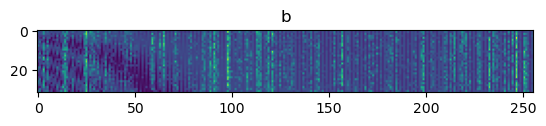

tensor([[[-0.4337,  2.1424, -0.0000,  ...,  1.2452,  0.0000,  0.3967],
         [-0.6921,  2.9849, -0.6921,  ...,  0.4190, -0.6921,  0.5197]],

        [[ 1.0822,  0.0000,  0.2501,  ...,  0.4702, -0.6408,  0.4702],
         [ 1.1972,  0.7941,  0.2126,  ...,  0.4327, -0.6783,  0.4327]],

        [[ 0.0000,  0.2472,  0.3839,  ...,  0.4304, -0.6805,  0.4304],
         [ 0.0000,  0.0290,  0.3562,  ...,  0.4500, -0.7082,  0.4027]],

        ...,

        [[-1.1396, -1.5307,  0.3673,  ...,  0.4115, -0.6961,  0.4115],
         [ 0.0168,  0.4579,  0.4049,  ...,  0.4491, -0.6585,  0.4491]],

        [[-1.3009,  2.2182, -0.3255,  ...,  0.0000, -0.7104,  0.5861],
         [-0.3154,  0.9914, -0.2591,  ...,  0.4635, -0.6310,  0.4635]],

        [[ 0.5558,  2.0829, -1.3611,  ...,  2.6565, -0.7546,  0.3528],
         [ 1.1156,  1.6085, -1.3351,  ...,  1.6459, -0.7286,  0.3788]]],
       grad_fn=<MulBackward0>)
tensor([[[-0.9102,  1.1288, -0.0086,  ..., -1.0509, -1.7860, -1.6545],
         [-0.6751,  

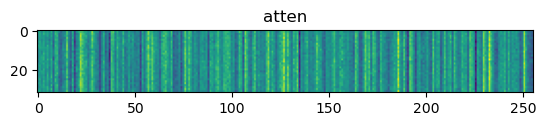

In [27]:
a = torch.rand(2,2048,16,32)        
a = a.permute(0,3,1,2)  # [batch , width , channel , height]
a = a.reshape(2,-1,32) # [batch , hidden , width ]

vertical_compression   = nn.Conv1d( 2048*16 , 256 , kernel_size=3 , padding=1)
b = vertical_compression(a)  # [batch , hidden , width ]
act                    = nn.ReLU()
layer_norm             = nn.LayerNorm(256)
b=b.permute(2,0,1)				# x: [sequence length, batch size, embed dim]
print(b.shape)
b = layer_norm(act(b))

pe                     = PositionalEncoding(256 , 0.1 , 32) 
b= pe(b)

encoder_layer = nn.TransformerEncoderLayer(d_model=256, nhead=8)
transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)

atten = transformer_encoder(b)
print(atten.shape)
plt.imshow(b.permute(1,0,2)[0].detach().cpu().numpy())
plt.title("b")
plt.show()

plt.imshow(atten.permute(1,0,2)[0].detach().cpu().numpy())
plt.title("atten")
plt.show()


In [ ]:
save_path = create_folder( os.path.join(os.getcwd() , "output" , "checkpoints"))
save_file = os.path.join(save_path , "detr_v1_d20_e50.pth")
torch.save(m , save_file)

In [ ]:
a= torch.rand(2,20,2)
b = torch.rand(20,2)
c = b.repeat(2,1,1)
print(c.shape)

In [ ]:
a= torch.rand(20,2)
b = torch.rand(20)*2
b = b.to(torch.long).view(-1,1)
#c = a[b]
c= torch.gather(a,1,b)
print(c.shape)
print(a)
print(b)
print()
print(c)

In [ ]:
decoder_layer = nn.TransformerDecoderLayer(d_model=512, nhead=8)
transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=6)
memory = torch.rand(10, 32, 512)
tgt = torch.rand(20, 32, 512)
out = transformer_decoder(tgt, memory)
print(out.shape)

In [ ]:
import torch
horizon_path =r"D:/OneDrive/OneDrive - NTHU/Layout/Horizon/0912_all_bk.pth"
#models_dict = torch.load_s
checkpoint = torch.load(horizon_path ,  map_location="cpu")
print(checkpoint['state_dict'].keys())
#model.load_state_dict(checkpoint['model_state_dict'])
pretrained_dict = {k: v for k, v in checkpoint['state_dict'].items() if k in m.state_dict()}
m.load_state_dict(pretrained_dict , strict=False)

In [ ]:
a= torch.rand(2,256 ,1024)
b = nn.Conv1d(256 , 64 , kernel_size=3 ,padding=1)
c = b(a)
print(c.shape)
